In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
datos = pd.read_csv('/content/drive/My Drive/Datos/california_housing_train.csv', delimiter=',')

In [4]:
datos.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-114.31,34.19,15,5612,1283,1015,472,1.4936,66900
1,-114.47,34.40,19,7650,1901,1129,463,1.8200,80100
2,-114.56,33.69,17,720,174,333,117,1.6509,85700
3,-114.57,33.64,14,1501,337,515,226,3.1917,73400
4,-114.57,33.57,20,1454,326,624,262,1.9250,65500


(array([14., 25., 20., 18.,  6.,  5.,  5.,  2.,  2.,  0.,  1.,  0.,  0.,
         1.,  1.]),
 array([ 202.        ,  604.66666667, 1007.33333333, 1410.        ,
        1812.66666667, 2215.33333333, 2618.        , 3020.66666667,
        3423.33333333, 3826.        , 4228.66666667, 4631.33333333,
        5034.        , 5436.66666667, 5839.33333333, 6242.        ]),
 <BarContainer object of 15 artists>)

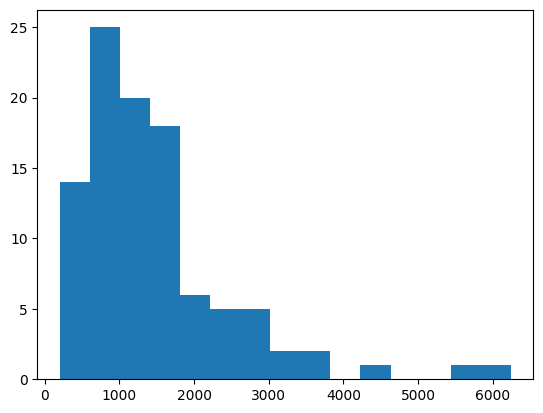

In [5]:
n = 100
sample_data = datos['population'].sample(n=n)  # serie de pandas
sample = sample_data.values                    # array de numpy
plt.hist(sample,bins='auto')

Vimos que si estimamos la distribución de los datos $F$ con la distribución empírica $\hat{F_n}$, podemos estimar cualquier funcional estadístico con su contraparte muestral.

Particularmente, el estimador del estadístico **media** $T(F) = \mu$ es el promedio muestral: $$\hat{\mu} = \bar{X_n} = \frac{1}{n}\sum_{i=1}^{n}X_i$$ y podemos calcular facilmente su desvío estándar, ya que es el error estándar del promedio muestral:


$$\text{se}(\hat{\mu}) = \sqrt{\text{var}(\bar{X_n})} = \frac{\sigma}{\sqrt{n}} $$

donde $\sigma$ es el desvío estándar de $X\sim F$. Por lo tanto, para estimar $\text{se}(\hat{\mu})$, reemplazamos $\sigma$ por $\hat{\sigma} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(X_i-\bar{X_n})^{2}}$, el desvío estándar muestral.

También podemos estimar un intervalo de confianza de nivel $1-\alpha$ para $\hat{\mu}$ como
$$\hat{\text{IC}}(\mu) = \hat{\mu} \pm z_{\frac{\alpha}{2}}\hat{\text{se}}(\hat{\mu}) $$

In [6]:
mean = np.mean(sample)    #Calculo el promedio muestral
std = np.std(sample)      #Calculo el desvío estándar muestral
se_mean = std/np.sqrt(n)  #Calculo el error estándar del promedio muestral


#Calculo el intervalo de confianza asintótico para la media
alpha = 0.05
low = mean - stats.norm.ppf(1-alpha/2)*se_mean
up = mean + stats.norm.ppf(1-alpha/2)*se_mean

print('µ_hat =',mean)
print('se(µ) =',se_mean)
print('IC(µ) = ',[low,up])

µ_hat = 1500.39
se(µ) = 105.07916624621649
IC(µ) =  [np.float64(1294.4386186319189), np.float64(1706.3413813680813)]


Ahora, ¿cómo calculo el error estándar y los intervalos de confianza para otros estadísticos?

# Bootstrap

Recordemos que estamos estimando la distribución subyacente a los datos $F$ con la función de distribución empírica $\hat{F_n}$. Como $\hat{F_n}$ le asigna una probabilidad puntual $1/n$ a cada $X_i$,
$\Rightarrow$
**tomar una observación de $\hat{F_n}$ equivale a tomar una observación al azar de la muestra original $X_1,...,X_n$**.

Entonces el método de bootstrap es simplemente seguir los siguientes pasos:



1.   Simulo una muestra $X_1^{*},...,X_n^{*} \sim \hat{F_n}$ tomando $n$ observaciones con reemplazo de $X_1,...,X_n$
2.   Calculo el funcional estadístico muestral deseado $T^{*}(\hat{F_n})$ a partir de $X_1^{*},...,X_n^{*}$
3. Repito **1.** y **2.** $m$ veces. Obtengo una muestra de $m$ valores de $T^{*}(\hat{F_n})$
4. Un estimador de la varianza de $\hat{\theta}_n = T(\hat{F_n})$ es la varianza muestral de $T^{*}(\hat{F_n})_m$. Es decir,

$$ v_{boot} (\hat{\theta}_n) = \frac{1}{m}\sum_{j=1}^{m} (T^{*}_{n,j} - \frac{1}{m}\sum_{i=1}^{m} T^{*}_{n,i} )^2$$
y
$$\hat{\text{se}} = \text{se}_{boot} =  \sqrt{v_{boot}}$$

5. A partir de la muestra de bootstrap podemos estimar un intervalo de confianza para $T(F)$ de varias maneras

## Intervalos de confianza

de nivel $1-\alpha$ para el estimador de un estadístico $\hat{\theta}_n$


---



1. Intervalo normal: $$\text{IC} = \hat{\theta}_n \pm z_{\frac{\alpha}{2}}\text{se}_{boot}$$


2. Percentile bootstrap: $$\text{IC} = (\hat{\theta}^*_{\frac{\alpha}{2}},\hat{\theta}^*_{1-\frac{\alpha}{2}}) $$

donde $\hat{\theta}^*_{\beta}$ es el $\beta$-percentil muestral de la muestra de bootstrap de $\hat{\theta}_{n,m}$


3. Basic bootstrap (intervalo pivotal): $$\text{IC} = (2\hat{\theta}_n - \hat{\theta}^*_{1-\frac{\alpha}{2}}, 2\hat{\theta}_n - \hat{\theta}^*_{\frac{\alpha}{2}}) $$

4. BCa bootsrap (*'bias-corrected and accelerated'*).

Es el que usa ``scipy.stats`` por default. Toma un IC de percentile bootstrap y le mete un factor que depende de dos parámetros: un 'parámetro de aceleración' $a$ y un 'factor de corrección de sesgo' $z_0$, que tiene que estimar



In [7]:
# algunas características muestrales
mean = np.mean(sample)       #promedio
var = np.var(sample)         #varianza
std = np.std(sample)         #desvío estándar (sqrt(var))
median = np.median(sample)   #mediana
quantile = np.quantile(sample,q = 0.25) #cuantiles
skewness = stats.skew(sample) #asimetría
#asimentria: si es negativa, tiene una cola más larga a la izquierda; positiva, a la derecha

#correlación
sample_id = sample_data.index
sample_2 = datos.loc[sample_id, 'latitude'].values
correlation = stats.pearsonr(sample,sample_2).statistic

print('media =',mean)
print('mediana =',median)
print('std =',std)
print('25-cuartil =',quantile)
print('asimetría = ',skewness)
print('correlación con Y:latitud =',correlation)

media = 1500.39
mediana = 1216.0
std = 1050.7916624621648
25-cuartil = 835.5
asimetría =  2.036564578588509
correlación con Y:latitud = -0.08673309838552941


In [8]:
sample = (sample,) # convierto la muestra en tupla para stats.bootstrap
alpha = 0.05
boot_res = stats.bootstrap(sample, np.std, confidence_level=1-alpha)
# param: muestra, estadistico, nivel de confianza

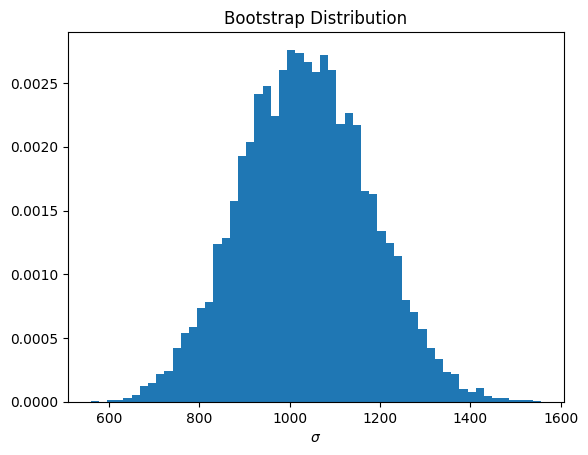

In [9]:
#grafico la distribución de bootstrap
fig, ax = plt.subplots()
ax.hist(boot_res.bootstrap_distribution, bins='auto',density=True)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel(r'$\sigma$')
plt.show()

In [11]:
len(boot_res.bootstrap_distribution)

9999

<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\h'
<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:31: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3839520822.py:24: SyntaxWarning: invalid escape sequence '\h'
  plt.axhline(std,color='k',ls='--',label='$\hat{\sigma}$',alpha=0.5)
/tmp/ipython-input-3839520822.py:31: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$IC(\hat{\sigma})$')


IC_normal =  [np.float64(775.464288735818), np.float64(1326.1190361885117)]
IC_percentile =  [np.float64(765.8442943258759), np.float64(1313.0426507570837)]
IC_basic =  [np.float64(784.9108598094572), np.float64(1335.828119597589)]
IC_bca =  [np.float64(828.2356523706306), np.float64(1394.0264673806776)]


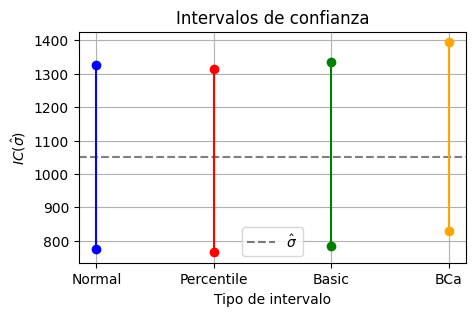

In [12]:
boot_percentile = stats.bootstrap(sample, np.std, confidence_level=1-alpha,method = 'percentile')
boot_basic = stats.bootstrap(sample, np.std, confidence_level=1-alpha,method = 'basic')
boot_bca = stats.bootstrap(sample, np.std, confidence_level=1-alpha,method = 'bca')

low_percentile = boot_percentile.confidence_interval.low
up_percentile = boot_percentile.confidence_interval.high

low_basic = boot_basic.confidence_interval.low
up_basic = boot_basic.confidence_interval.high

low_bca = boot_bca.confidence_interval.low
up_bca = boot_bca.confidence_interval.high

low_normal = std - stats.norm.ppf(1-alpha/2)*boot_percentile.standard_error #puede ser el error estándar de cualquiera
up_normal = std + stats.norm.ppf(1-alpha/2)*boot_percentile.standard_error

print('IC_normal = ',[low_normal,up_normal])
print('IC_percentile = ',[low_percentile,up_percentile])
print('IC_basic = ',[low_basic,up_basic])
print('IC_bca = ',[low_bca,up_bca])

plt.figure(figsize=(5, 3))
interval_names = ['Normal', 'Percentile', 'Basic', 'BCa']
plt.axhline(std,color='k',ls='--',label='$\hat{\sigma}$',alpha=0.5)
plt.plot([1, 1], [low_normal, up_normal],'o-', color='blue')
plt.plot([2, 2], [low_percentile, up_percentile],'o-', color='red')
plt.plot([3, 3], [low_basic, up_basic],'o-', color='green')
plt.plot([4, 4], [low_bca, up_bca],'o-', color='orange')
plt.xticks([1,2,3,4],labels=interval_names)
plt.xlabel('Tipo de intervalo')
plt.ylabel('$IC(\hat{\sigma})$')
plt.title('Intervalos de confianza')
plt.legend()
plt.grid()
plt.show()

### Ejercicio 7

- $X_1,...,X_{100} \sim N(\mu,1)$
- $\theta = e^{\mu} \hspace{1cm} \hat{\theta} = e^{\bar{X}}$
- Usando $\mu = 5$ queremos obtener el error estandar y un IC de nivel 95 para $\theta$

In [21]:
alpha=0.05
n=100
mu=5
norm_sample = stats.norm.rvs(size=n,loc=mu,scale=1.0)
norm_sample = (norm_sample,)

def theta_hat(sample):
  return np.exp(np.mean(sample))

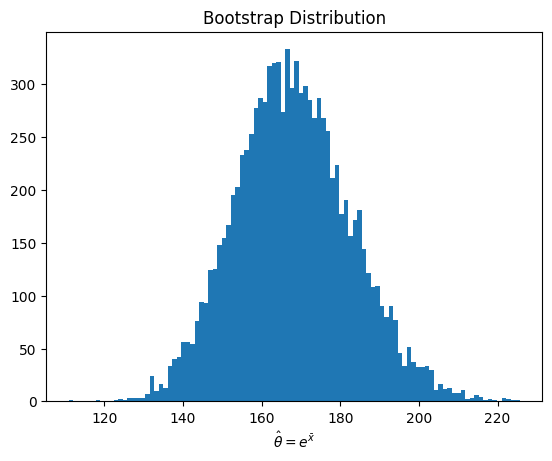

In [22]:
boot_percentile = stats.bootstrap(norm_sample, theta_hat, confidence_level=1-alpha,method = 'percentile')

fig, ax = plt.subplots()
ax.hist(boot_percentile.bootstrap_distribution, bins=100)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel(r'$\hat{\theta}=e^{\bar{x}}$')
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\h'
<>:26: SyntaxWarning: invalid escape sequence '\h'
<>:34: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-633204765.py:26: SyntaxWarning: invalid escape sequence '\h'
  plt.axhline(theta_hat(norm_sample),color='k',ls='--',label='$\hat{\\theta}$',alpha=0.5)
/tmp/ipython-input-633204765.py:34: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('$IC(\hat{\sigma})$')


se=  14.806123781967516
IC_normal =  [np.float64(138.33702475730703), np.float64(196.37596348390363)]
IC_percentile =  [np.float64(140.87338577328677), np.float64(198.71223462266366)]
IC_basic =  [np.float64(135.81858370125056), np.float64(194.43724565603975)]
IC_bca =  [np.float64(140.0117234890515), np.float64(196.9093183224447)]


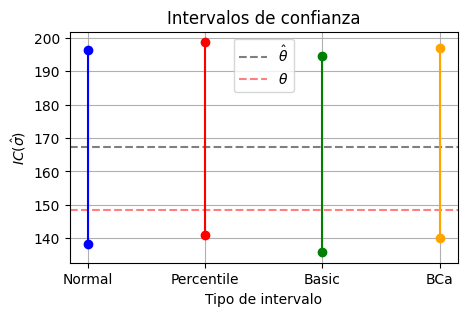

In [23]:
boot_percentile = stats.bootstrap(norm_sample, theta_hat, confidence_level=1-alpha,method = 'percentile')
boot_basic = stats.bootstrap(norm_sample, theta_hat, confidence_level=1-alpha,method = 'basic')
boot_bca = stats.bootstrap(norm_sample, theta_hat, confidence_level=1-alpha,method = 'bca')

print('se= ',boot_percentile.standard_error)

low_percentile = boot_percentile.confidence_interval.low
up_percentile = boot_percentile.confidence_interval.high

low_basic = boot_basic.confidence_interval.low
up_basic = boot_basic.confidence_interval.high

low_bca = boot_bca.confidence_interval.low
up_bca = boot_bca.confidence_interval.high

low_normal = theta_hat(norm_sample) - stats.norm.ppf(1-alpha/2)*boot_percentile.standard_error #puede ser el error estándar de cualquiera
up_normal = theta_hat(norm_sample) + stats.norm.ppf(1-alpha/2)*boot_percentile.standard_error

print('IC_normal = ',[low_normal,up_normal])
print('IC_percentile = ',[low_percentile,up_percentile])
print('IC_basic = ',[low_basic,up_basic])
print('IC_bca = ',[low_bca,up_bca])

plt.figure(figsize=(5, 3))
interval_names = ['Normal', 'Percentile', 'Basic', 'BCa']
plt.axhline(theta_hat(norm_sample),color='k',ls='--',label='$\hat{\\theta}$',alpha=0.5)
plt.axhline(np.exp(mu),color='r',ls='--',label='$\\theta$',alpha=0.5)
plt.plot([1, 1], [low_normal, up_normal],'o-', color='blue')
plt.plot([2, 2], [low_percentile, up_percentile],'o-', color='red')
plt.plot([3, 3], [low_basic, up_basic],'o-', color='green')
plt.plot([4, 4], [low_bca, up_bca],'o-', color='orange')
plt.xticks([1,2,3,4],labels=interval_names)
plt.xlabel('Tipo de intervalo')
plt.ylabel('$IC(\hat{\sigma})$')
plt.title('Intervalos de confianza')
plt.legend()
plt.grid()
plt.show()

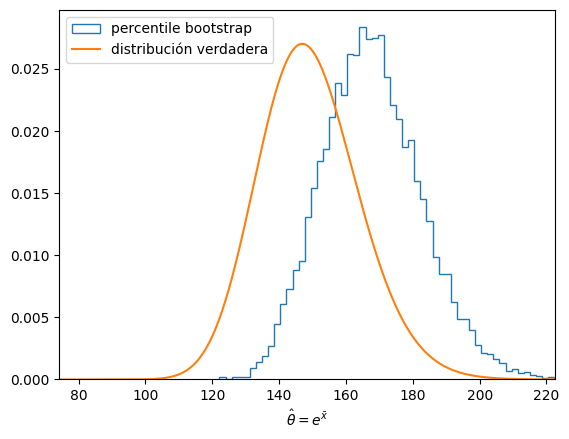

In [24]:
x = np.linspace(mu-10,mu+10,10000)
plt.hist(boot_percentile.bootstrap_distribution,density=True,bins='auto',histtype='step',label='percentile bootstrap')
norm_pdf = stats.norm.pdf(x, loc=mu, scale=np.sqrt(1/n))

plt.plot(np.exp(x),norm_pdf/np.exp(x),label='distribución verdadera')
plt.xlim(np.exp(mu)*0.5,np.exp(mu)*1.5)
plt.xlabel(r'$\hat{\theta}=e^{\bar{x}}$')
plt.legend()

In [ ]:
theta_hat_axis = np.linspace(np.exp(mu)*.5,np.exp(mu)*1.5,10000)
numerador_theta_hat_pdf  = stats.norm.pdf(np.log(theta_hat_axis), loc=mu, scale=np.sqrt(1/n))
theta_hat_pdf = numerador_theta_hat_pdf / theta_hat_axis

plt.hist(boot_percentile.bootstrap_distribution,density=True,bins='auto',histtype='step',label='percentile bootstrap')
plt.plot(theta_hat_axis,theta_hat_pdf,label='distribución verdadera')
plt.axvline(np.exp(mu), color='red', linestyle='--', label=r'$\theta$')
plt.xlim(np.exp(mu)*0.5,np.exp(mu)*1.5)
plt.xlabel(r'$\hat{\theta}=e^{\bar{x}}$')

plt.legend()
plt.show()

¿Por qué pasa esto? ¿ Si corro nuevamente, me da lo mismo?